# Problem 1: Rejection Sampling

Implement a rejection sampler corresponding to the example figure above that illustrates the method. For this example,

* $p(x)$ is the $\chi^2$ distribution with 3 degrees of freedom

* $A=\pi$

* $g(x)$ is a normal distribution with mean 0 and standard deviation 5

Verify that your samples do indeed approximate the target PDF.

(array([344., 296., 174., 101.,  52.,  20.,   8.,   2.,   1.,   2.]),
 array([ 0.03352686,  1.64843524,  3.26334363,  4.87825202,  6.4931604 ,
         8.10806879,  9.72297718, 11.33788556, 12.95279395, 14.56770234,
        16.18261072]),
 <a list of 10 Patch objects>)

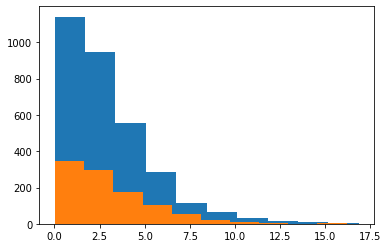

In [1]:
import scipy.stats as sp
import matplotlib.pyplot as plt
import numpy as np

A = np.pi
samples =[]
p_x = []
n = np.random.normal(0,5,10000)

for x in n:
    g = sp.norm.pdf(x,loc = 0, scale = 5)
    u = np.random.uniform(0,1)
    p = (sp.chi2.pdf(x, df = 3))
    env = p/(A*g)
    if u <= env:
        samples.append(x)
        
#Verify that your samples do indeed approximate the target PDF
plt.hist(samples)
plt.hist(np.random.chisquare(3,1000))

This technique is at the heart of a  very widely used (by scientists anyway) and simple to implement technique: the **Metropolis-Hastings** algorithm, which is one example of *Markov Chain Monte Carlo.*

### Markov Chains

A Markov Chain is a sequence where the $n$th entry depends explicitly on the $(n-1)$th, but not (explicitly) on previous steps. The chain will be a random walk through parameter space.


### Formalities of MCMC

Markov chains provide a powerful way to sample PDFs, provided that the transition kernel/proposal distribution - how we go from state 1 to state 2  satisfies a few requirements
* Detailed balance: any transition must be reversible; the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$
* Ergodicity: the process may not be periodic, but it nevertheless must be possible to return to a given state in finite time
* It must be possible, in principle, to reach any state with non-zero prior probability

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$


## Metropolis-Hastings
This algorithm can be thought of as an MCMC adaptation of rejection sampling. We need to define
1. An initial state (parameter values)
2. A proposal distribution, $g(x'|x)$, giving the probability that we attempt to move from $x$ to $x'$.

Let $P$ be the distribution we want to sample. The algorithm is then
```
set x to an initial state
compute p(x)
while we want more samples
    draw x' from the proposal distribution g(x'|x)
    compute p(x')
    draw u from Uniform(0,1)
    if u <= p(x')/p(x) * g(x|x')/g(x'|x), set the state x=x'
    otherwise, x stays the same
    store x as a sample
```

Compare this to the rejection sampling algorithm above!

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!


### Metropolis
If the proposal distribution is translation invariant (i.e. only depends on the distance between the points), $g(x'|x)=g\left(\left|x'-x\right|\right)$, then it drops out of the *acceptance ratio* that decides whether to accept a step. 

**The most basic choice you can make is a Gaussian.**

For an N-dimensional Gaussian proposal function, $g$,  an *acceptance fraction* $A$ of $\sim25\%$ is optimal.

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')}{p(x)}\right]$$

This is the original Metropolis algorithm, and is the easiest case to implement.

In this case, we *always* accept a jump to higher $p$, and *sometimes* accept one to lower $p$.

You'll have to tune the $\sigma$ of your Gaussian proposal function g by hand to make sure that your get a ~25% acceptance ratio. Note that this sigma is simply telling you the distribution of $x'$ from $x$.

# Problem 2: Metropolis


You guessed it... Implement the Metroplis Hastings algorithm in python.
Your implementation should accept an arbitary function as an argument (just as you've been passing to `scipy.optimize`)

Test it by sampling both the `circle` and `pgauss` function below 10,000 times and plotting your samples as you did in class (don't plot up your rejected). You can implement a prior function that imposes bounds. 

Look at your first 100 samples and then samples 500 to 600 for the `pgauss` case and comment on the difference. Think about this on Problem 3!

set x to an initial state
compute p(x)
while we want more samples
    draw x' from the proposal distribution g(x'|x)
    compute p(x')
    draw u from Uniform(0,1)
    if u <= p(x')/p(x) * g(x|x')/g(x'|x), set the state x=x'
    otherwise, x stays the same
    store x as a sample

Text(0.5, 0.98, 'Metroplis Hastings for Circle p(x)')

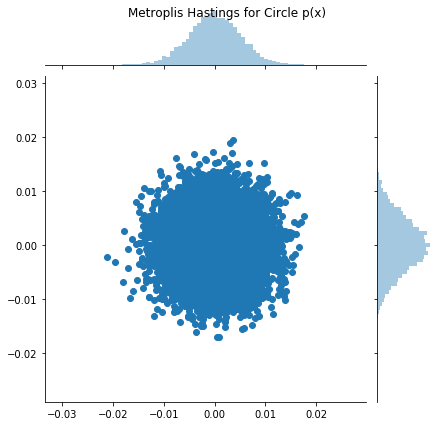

In [3]:
def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2

mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

def pgauss(x, y):
    return sp.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)

def mHasty(function, sigma):
    xi, yi = np.random.normal(0, sigma, size=2)
    sample = np.zeros((10000, 2))
    
    p_prob = function(xi,yi)
    
    #x_prime = np.random.normal(0,1,10000)
    #y_prime = np.random.normal(0,1,10000)
    
    for i in range(10000):
        x_prime, y_prime = np.random.normal(0,sigma,size=2)
        p_new = function(x_prime,y_prime)
        unif = np.random.uniform(0,1)
    
        if unif <= (p_new/p_prob)*1:
            x,y = x_prime, y_prime
            sample[i] = np.array([x,y])
        else:
            sample[i] = np.array([xi,yi])
        
    return sample

import seaborn as sns

circlesx = mHasty(circle,sigma = .005)[:,0]
circlesy = mHasty(circle,sigma = .005)[:,1]

c = sns.jointplot(circlesx,circlesy)
c.fig.suptitle('Metroplis Hastings for Circle p(x)')

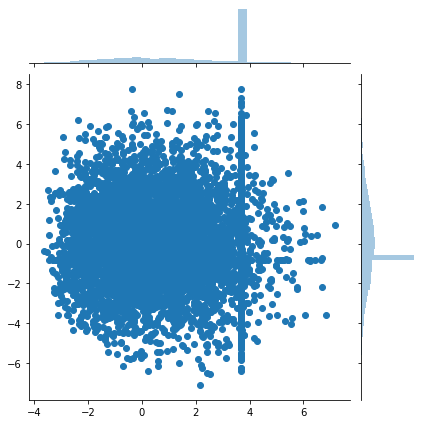

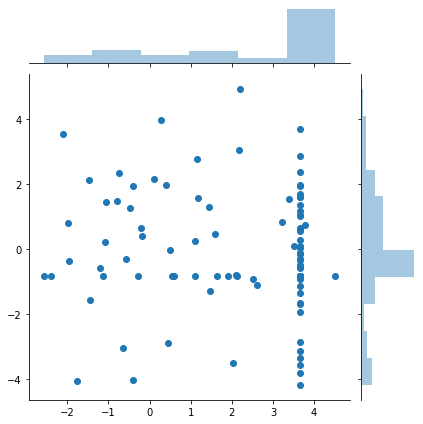

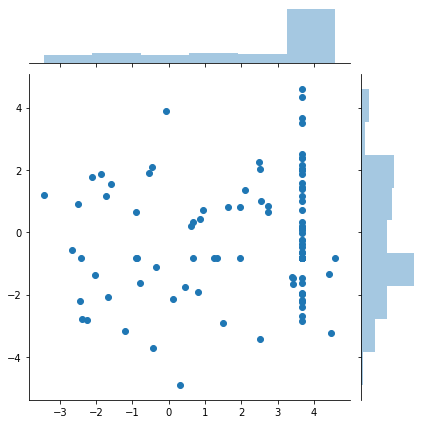

In [83]:
pgaussx = mHasty(pgauss, sigma = 2.5)[:,0]
pgaussy = mHasty(pgauss, sigma = 2.5)[:,1]

first100x = pgaussx[:100]
first100y = pgaussy[:100]

fivetosixx = pgaussx[500:600]
fivetosixy = pgaussy[500:600]

#NOTE: something is wrong with my metroplis hastings and these plots :( 

sns.jointplot(pgaussx, pgaussy)
sns.jointplot(first100x, first100y)
sns.jointplot(fivetosixx, fivetosixy)

## Problem 3: Using your sampler for a real problem where a grid would have been really painful.


We'll be analyzing data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

You can read more about microlensing here if you like:
https://en.wikipedia.org/wiki/Gravitational_microlensing

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). Scroll down a bit to the list of recent events and choose one to analyze. (Not the one shown below. Be original.) The event summary page will include a plot like this.

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2019/data/2019/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

As long as a vaguely reasonable looking magenta line is shown, this should be a good data set to fit. Download the `phot.dat` for your chosen event (linked at the bottom of the webpage).

As described on the OGLE page, the columns of this text file are

> Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

* Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time more or less that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

* Measurements of magnitude in the $I$ band (a near infrared band). Recall that astronomical magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux.

* Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

* The "seeing" and "sky level" quantities refer to the observing conditions, which we will not work with directly. These will have been accounted for (somehow) in deriving the best-fitting magnitude and its uncertainty.


As Bayesian's we have 4 questions to answer
1. What's the model?
2. What's the Likelihood?
3. What's the Prior?
4. How do you sample?


I'll tell you 1. and you've already written down the answer to 4.


## $$F(t) = F_0 \frac{u(t)^2 + 2}{u(t)\sqrt{u(t)^2+4}}$$

where

## $$u(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$$

You'll of course also need the transformation between flux and magnitude, above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, i.e. $I_0$ rather than $F_0$; that way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$. 

* $t_\mathrm{E}$ is the Einstein crossing time - you can also get some initial guess for this from the data itself

* $t_\mathrm{max}$ is the time of maximum - which you should be able to read off from the plot

* $p$ is the peak magnification - You can also get a guess of this and $I_0$ from the data. Look at the functional form of the model at times far from $t_\mathrm{max}$.


Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements are Gaussian and independent, with means given by the "magnitude" column and standard deviations given by the "magnitude error" column, and that the time stamps are exact.


Do an MCMC fit of this microlensing model to your lightcurve data
This fit should be doable, if potentially annoying, with your Metropolis-Hastings implementation.

Your solution should include the following:

1. expressions (in readable code, at a minimum) of the prior distributions and likelihood encoded (i.e. Q2 for a Bayesian)
2. some justification of the choice of priors (Q3. for a Bayesian can be brief)
3. plots showing traces of each parameter, and an identified burn-in period
4. some evaluation of how well the fit has converged (see below)
5. 1D histograms of the parameter samples and 2D contour plots of parameter pairs (you can just use the `corner` package for this, which makes it trivial - you can see how in homework from week 1)
6. "best fit" values and 68.3% confidence intervals from the 1D marginalized posteriors of each parameter. 
7. a plot of the best-fitting model lightcurve over the data, and some qualitative comments about how good a fit it appears (hint: depending on your data set, you may need to zoom in quite a lot to get a good look)

In [7]:
import numpy as np
import pandas as pd

In [62]:
data = np.loadtxt("phot.dat.txt", float)

time = data[:,0]
i_tru = data[:,1]
sig_tru = data[:,2]

In [86]:
def u_func(p, t, t_max, t_E):
    return(np.sqrt( p**2 + ((t-t_max)/t_E))**2 )

def Imag(p, t, t_max, t_E):
    u = u_func(p,t,t_max,t_E)
    I_0 = 16.688
    top = I_0*((u**2) + 2)
    bot = u*np.sqrt((u**2) + 4)
    return (top/bot)

array([16.688, 16.688, 16.688, ..., 16.688, 16.688, 16.688])

In [63]:
def chi2(Iobs,Iexp,sig):
    for i in range(len(Iobs)):
        top = (Iobs[i] - Iexp)**2
        bot = (sig[i])**2
        return(np.sum(top/bot))

In [117]:
i_exp = []
for i in range(len(i_tru)):
    i_exp.append(Imag(p = 16.7/16.5, t = time[i], t_max = 8517, t_E = 8495))
    
chisq = chi2(i_tru, i_exp, sig_tru)

chisq

689.2509371159802

In [116]:
i_new = []

for i in range(10000):
    p_new = np.random.normal(1,.05)
    t = np.random.normal(2458175, 400) 
    max_t = np.random.normal(8517,10)
    E_t = np.random.normal(8495,10)
    
    i_mag = Imag(p = p_new, t = t, t_max = max_t, t_E = E_t)
    
    i_new.append(i_mag)
    
chisq_new = chi2(Iobs = i_tru, Iexp = i_mag, sig = sig_tru)

chisq_new

0.25000033809726024

I am having a hard time making a function for my sampling - I want to use chi squared to compare my drawn values with my actual data.

The plan: use chi squared to calculate 2 liklihood functions that I can multiply by the priors, then compare my {"uniform dist" <= ratio of liklihood x prior} to accept or reject values 

However, I don't know how to implement chi squared at every step in which I draw a value, when my chi2 function (or any chi 2 calculation) involves comparing two SETS of data (not 2 distinct values). 

I also don't know how I should be randomizing my parameters other than pulling from a random normal distribution.

Turning in this HW for the sake of getting it turned in but also still trying to mess with this.